# Checkpoint 1

Reminder: 

- You are being evaluated for completion and effort in this checkpoint. 
- Avoid manual labor / hard coding as much as possible, everything we've taught you so far are meant to simplify and automate your process.

We will be working with the same `states_edu.csv` that you should already be familiar with from the tutorial.

We investigated Grade 8 reading score in the tutorial. For this checkpoint, you are asked to investigate another test. Here's an overview:

* Choose a specific response variable to focus on
>Grade 4 Math, Grade 4 Reading, **Grade 8 Math**
* Pick or create features to use
>Will all the features be useful in predicting test score? Are some more important than others? Should you standardize, bin, or scale the data?
* Explore the data as it relates to that test
>Create at least 2 visualizations (graphs), each with a caption describing the graph and what it tells us about the data
* Create training and testing data
>Do you want to train on all the data? Only data from the last 10 years? Only Michigan data?
* Train a ML model to predict outcome 
>Define what you want to predict, and pick a model in sklearn to use (see sklearn <a href="https://scikit-learn.org/stable/modules/linear_model.html">regressors</a>).


Include comments throughout your code! Every cleanup and preprocessing task should be documented.

In [1]:
import random
import numpy as np

seed = 420 # Seed for project
random.seed(seed)
np.random.seed(seed)

<h2> Data Cleanup </h2>

Import `numpy`, `pandas`, and `matplotlib`.

(Feel free to import other libraries!)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Load in the "states_edu.csv" dataset and take a look at the head of the data

In [3]:
df: pd.DataFrame = pd.read_csv("../data/states_edu.csv")

You should always familiarize yourself with what each column in the dataframe represents. Read about the states_edu dataset here: https://www.kaggle.com/noriuk/us-education-datasets-unification-project

Use this space to rename columns, deal with missing data, etc. _(optional)_

<h2>Exploratory Data Analysis (EDA) </h2>

Chosen one of Grade 4 Reading, Grade 4 Math, or Grade 8 Math to focus on: ***Grade 8 Math***

In [4]:
RESULT_COLUMN: str = "AVG_MATH_8_SCORE"

How many years of data are logged in our dataset? 

In [5]:
num_years = df['YEAR'].nunique()
num_years

33

Let's compare Michigan to Ohio. Which state has the higher average across all years in the test you chose?

In [6]:
mi_df = df.loc[df["STATE"] == "MICHIGAN"]
oh_df = df.loc[df["STATE"] == "OHIO"]

avg_mi = mi_df[RESULT_COLUMN].mean()
avg_oh = oh_df[RESULT_COLUMN].mean()

print('MI' if avg_mi > avg_oh else 'OH', max(avg_mi, avg_oh))

OH 282.25


Find the average for your chosen test across all states in 2019

In [7]:
df_2019 = df.loc[df['YEAR'] == 2019]
avg_score_2019 = df_2019[RESULT_COLUMN].mean()
avg_score_2019

281.2641509433962

For each state, find a maximum value for your chosen test score

In [8]:
max_by_state = df.groupby('STATE')[RESULT_COLUMN].max()
max_by_state

STATE
ALABAMA                 269.0
ALASKA                  283.0
ARIZONA                 283.0
ARKANSAS                279.0
CALIFORNIA              277.0
COLORADO                292.0
CONNECTICUT             289.0
DELAWARE                284.0
DISTRICT_OF_COLUMBIA    269.0
DODEA                   293.0
FLORIDA                 281.0
GEORGIA                 281.0
HAWAII                  281.0
IDAHO                   287.0
ILLINOIS                285.0
INDIANA                 288.0
IOWA                    286.0
KANSAS                  290.0
KENTUCKY                282.0
LOUISIANA               273.0
MAINE                   289.0
MARYLAND                288.0
MASSACHUSETTS           301.0
MICHIGAN                280.0
MINNESOTA               295.0
MISSISSIPPI             274.0
MISSOURI                286.0
MONTANA                 293.0
NATIONAL                285.0
NEBRASKA                288.0
NEVADA                  278.0
NEW_HAMPSHIRE           296.0
NEW_JERSEY              296.0
NEW_

*Refer to the `Grouping and Aggregating` section in Tutorial 0 if you are stuck.

<h2> Feature Engineering </h2>

After exploring the data, you can choose to modify features that you would use to predict the performance of the students on your chosen response variable. 

You can also create your own features. For example, perhaps you figured that maybe a state's expenditure per student may affect their overall academic performance so you create a expenditure_per_student feature.

Use this space to modify or create features.

In [9]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    # Convert PRIMARY_KEY and STATE to categorical data types
    df['PRIMARY_KEY'] = df['PRIMARY_KEY'].astype('category')
    df['STATE'] = df['STATE'].astype('category')

    # Encode STATE column using LabelEncoder
    le = LabelEncoder()
    df['STATE'] = le.fit_transform(df['STATE'])

    # Rename variables for clarity
    df = df.rename({
    'GRADES_PK_G':'ENROLL_PREK',
    'GRADES_KG_G':'ENROLL_KINDER',
    'GRADES_4_G':'ENROLL_4',
    'GRADES_8_G':'ENROLL_8',
    'GRADES_12_G':'ENROLL_12',
    'GRADES_1_8_G':'ENROLL_PRIMARY',
    'GRADES_9_12_G':'ENROLL_HS',
    'GRADES_ALL_G':'ENROLL_ALL',
    'ENROLL':'ENROLL_ALL_EST',

    RESULT_COLUMN: 'target',
    },
    axis=1)

    return df

current_features: list[str]

def generate_features(df: pd.DataFrame, with_identifiers: bool=True, with_other_score: bool=True) -> tuple[pd.DataFrame, pd.DataFrame]:
    global current_features

    # Define base features
    features: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 
            'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 
            'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE', 'ENROLL_8', 'ENROLL_HS', 'ENROLL_ALL', 'ENROLL_ALL_EST']
    
    # Add optional features based on parameters
    if with_identifiers:
        features.extend(['YEAR', 'STATE'])
    if with_other_score:
        features.extend(['AVG_READING_8_SCORE'])
        
    financial_metrics: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', 
                            'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE',
                            'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']
    
    # Calculate financial ratios
    df = df.sort_values(['STATE', 'YEAR'])
    financial_denoms: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 
            'LOCAL_REVENUE', 'TOTAL_EXPENDITURE']
    
    for metric in financial_metrics:
        for denom in financial_denoms:
            relative_ratio = f'{metric}_{denom}_REL'
            df[relative_ratio] = df[metric] / df[denom]
            features.append(relative_ratio)
        
    # Calculate enrollment ratios
    df['GRADE_8_TO_HS_RATIO'] = df['ENROLL_8'] / df['ENROLL_HS']
    df['GRADE_8_TO_ALL_RATIO'] = df['ENROLL_8'] / df['ENROLL_ALL']
    features.extend(['GRADE_8_TO_HS_RATIO', 'GRADE_8_TO_ALL_RATIO'])

    # Calculate per-student metrics
    per_student_metrics = ['TOTAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE']
    for metric in per_student_metrics:
        per_student = f'{metric}_PER_STUDENT'
        df[per_student] = df[metric] / df['ENROLL_ALL']
        features.append(per_student)

    current_features = features.copy()

    # Sort dataframe by index and return features and target
    df = df.sort_index()
    return df[features], df['target']

def clean_data(df_features: pd.DataFrame, df_target: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X = df_features.values
    Y = df_target.values

    # Remove rows with non finite targets.
    X = X[np.isfinite(Y)]
    Y = Y[np.isfinite(Y)]

    index = np.arange(len(X))
    return X, Y, index

def _clean_data(df_features: pd.DataFrame, df_target: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    X = df_features.values
    Y = df_target.values

    X = df_features[np.isfinite(Y)]
    Y = df_target[np.isfinite(Y)]

    return X, Y

Feature engineering justification: The changes made in the feature engineering process were designed to create more informative and normalized features that could potentially improve the model's predictive power. Here's a brief explanation of the key changes:

1. Financial ratios: By creating relative ratios between different financial metrics, we can capture the proportional relationships between various revenue and expenditure categories. This allows the model to understand the financial structure of each state's education system, regardless of the absolute dollar amounts.

2. Enrollment ratios: The GRADE_8_TO_HS_RATIO and GRADE_8_TO_ALL_RATIO features provide insights into the relative size of the 8th-grade cohort compared to high school and overall enrollment. This could help identify any potential issues with student retention or progression through the school system.

3. Per-student metrics: By calculating revenue and expenditure amounts per student, we normalize these financial metrics across states with different population sizes. This allows for more meaningful comparisons and could reveal insights into how resource allocation affects student performance.

4. Inclusion of reading scores: By including the AVG_READING_8_SCORE as a feature, we allow the model to consider the potential correlation between reading and math performance, which could be a strong predictor.

These engineered features aim to provide a more comprehensive view of each state's educational context, potentially allowing the model to identify more nuanced relationships between various factors and the target variable (math scores).

Note that reading scores and identifiers such as `STATE` and `YEAR` were removed in this submission to prevent overfitting and trivialization:

```
Model Performance with scores and identifiers:
Mean Squared Error: 17.50613688729913
Mean Absolute Error: 3.014907710562681
R-squared Score: 0.8128921389234358
```

<h2>Visualization</h2>

Investigate the relationship between your chosen response variable and at least two predictors using visualizations. Write down your observations.

**Visualization 1**

In [10]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    
    df['PRIMARY_KEY'] = df['PRIMARY_KEY'].astype('category')
    df['STATE'] = df['STATE'].astype('category')

    # Encode categorical variables
    le = LabelEncoder()
    df['STATE'] = le.fit_transform(df['STATE'])

    # Rename variables
    df = df.rename({
    'GRADES_PK_G':'ENROLL_PREK',
    'GRADES_KG_G':'ENROLL_KINDER',
    'GRADES_4_G':'ENROLL_4',
    'GRADES_8_G':'ENROLL_8',
    'GRADES_12_G':'ENROLL_12',
    'GRADES_1_8_G':'ENROLL_PRIMARY',
    'GRADES_9_12_G':'ENROLL_HS',
    'GRADES_ALL_G':'ENROLL_ALL',
    'ENROLL':'ENROLL_ALL_EST',

    RESULT_COLUMN: 'target',
    },
    axis=1)

    return df

current_features: list[str]

def generate_features(df: pd.DataFrame, with_identifiers: bool=False, with_other_score: bool=False) -> tuple[pd.DataFrame, pd.DataFrame]:
    global current_features
    features: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 
            'LOCAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 
            'SUPPORT_SERVICES_EXPENDITURE', 'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']
    
    if with_identifiers:
        features.extend(['YEAR', 'STATE', 'ENROLL_8', 'ENROLL_HS', 'ENROLL_ALL', 'ENROLL_ALL_EST'])
    if with_other_score:
        features.extend(['AVG_READING_8_SCORE'])
        
    financial_metrics: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 'LOCAL_REVENUE', 
                            'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE', 'SUPPORT_SERVICES_EXPENDITURE',
                            'OTHER_EXPENDITURE', 'CAPITAL_OUTLAY_EXPENDITURE']
    
    df = df.sort_values(['STATE', 'YEAR'])
    financial_denoms: list[str] = ['TOTAL_REVENUE', 'FEDERAL_REVENUE', 'STATE_REVENUE', 
            'LOCAL_REVENUE', 'TOTAL_EXPENDITURE']
    
    for metric in financial_metrics:
        for denom in financial_denoms:
            relative_ratio = f'{metric}_{denom}_REL'
            df[relative_ratio] = df[metric] / df[denom]
            features.append(relative_ratio)
        
    df['GRADE_8_TO_HS_RATIO'] = df['ENROLL_8'] / df['ENROLL_HS']
    df['GRADE_8_TO_ALL_RATIO'] = df['ENROLL_8'] / df['ENROLL_ALL']
    features.extend(['GRADE_8_TO_HS_RATIO', 'GRADE_8_TO_ALL_RATIO'])

    per_student_metrics = ['TOTAL_REVENUE', 'TOTAL_EXPENDITURE', 'INSTRUCTION_EXPENDITURE']
    for metric in per_student_metrics:
        per_student = f'{metric}_PER_STUDENT'
        df[per_student] = df[metric] / df['ENROLL_ALL']
        features.append(per_student)

    current_features = features.copy()

    df = df.sort_index()
    return df[features], df['target']

def clear_nan(features_df: pd.DataFrame, target_df: pd.Series, feature_list: list[str]) -> tuple[pd.DataFrame, pd.Series]:
# Ensure all specified features exist in the DataFrame
    assert all(feature in features_df.columns for feature in feature_list), "Not all specified features exist in the DataFrame"
    
    # Create a mask for finite values in specified features
    feature_mask = np.all(features_df[feature_list].apply(np.isfinite), axis=1)
    
    target_mask = np.isfinite(target_df)
    
    # Combine masks
    valid_mask = feature_mask & target_mask
    
    # Apply mask to both DataFrames
    cleaned_features_df = features_df[valid_mask]
    cleaned_target_df = target_df[valid_mask]
    
    # Reset index for both DataFrames
    cleaned_features_df = cleaned_features_df.reset_index(drop=True)
    cleaned_target_df = cleaned_target_df.reset_index(drop=True)
    
    return cleaned_features_df, cleaned_target_df

def clean_data(df_features: pd.DataFrame, df_target: pd.DataFrame) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    X = df_features.values
    Y = df_target.values

    X = X[np.isfinite(Y)]
    Y = Y[np.isfinite(Y)]

    index = np.arange(len(X))
    return X, Y, index

def _clean_data(df_features: pd.DataFrame, df_target: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    X = df_features.values
    Y = df_target.values

    X = df_features[np.isfinite(Y)]
    Y = df_target[np.isfinite(Y)]

    return X, Y

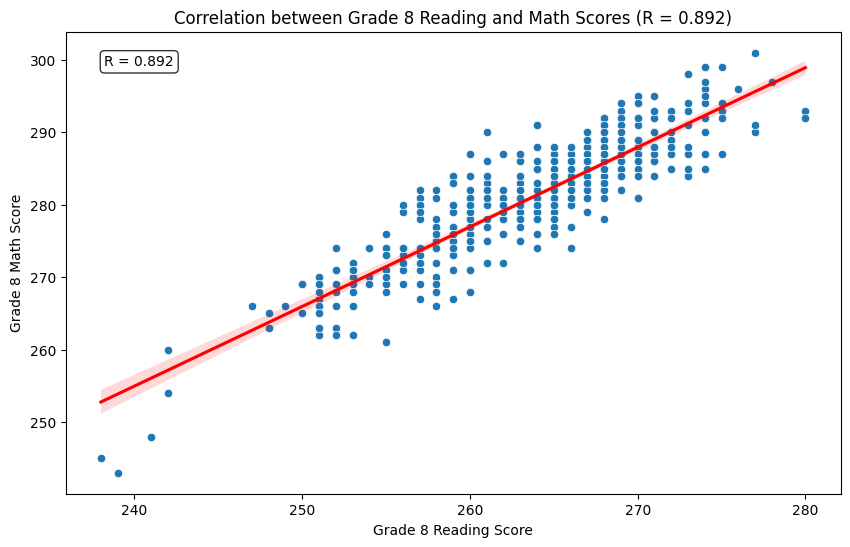

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df: pd.DataFrame = pd.read_csv("../data/states_edu.csv")

# Remove NaN values and calculate correlation coefficient
valid_mask = ~(np.isnan(df['AVG_READING_8_SCORE']) | np.isnan(df[RESULT_COLUMN]))
x_valid = df['AVG_READING_8_SCORE'][valid_mask]
y_valid = df[RESULT_COLUMN][valid_mask]

r = np.corrcoef(x_valid, y_valid)[0, 1]

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AVG_READING_8_SCORE', y=RESULT_COLUMN, data=df)

# Add a trend line
sns.regplot(x='AVG_READING_8_SCORE', y=RESULT_COLUMN, data=df, scatter=False, color='red')

# Add labels and title
plt.xlabel('Grade 8 Reading Score')
plt.ylabel('Grade 8 Math Score')
plt.title(f'Correlation between Grade 8 Reading and Math Scores (R = {r:.3f})')

# Add R-value to the plot
plt.text(0.05, 0.95, f'R = {r:.3f}', transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

**Correlation between average 8th grade reading scores by state and average 8th grade math score**

**Visualization 2**

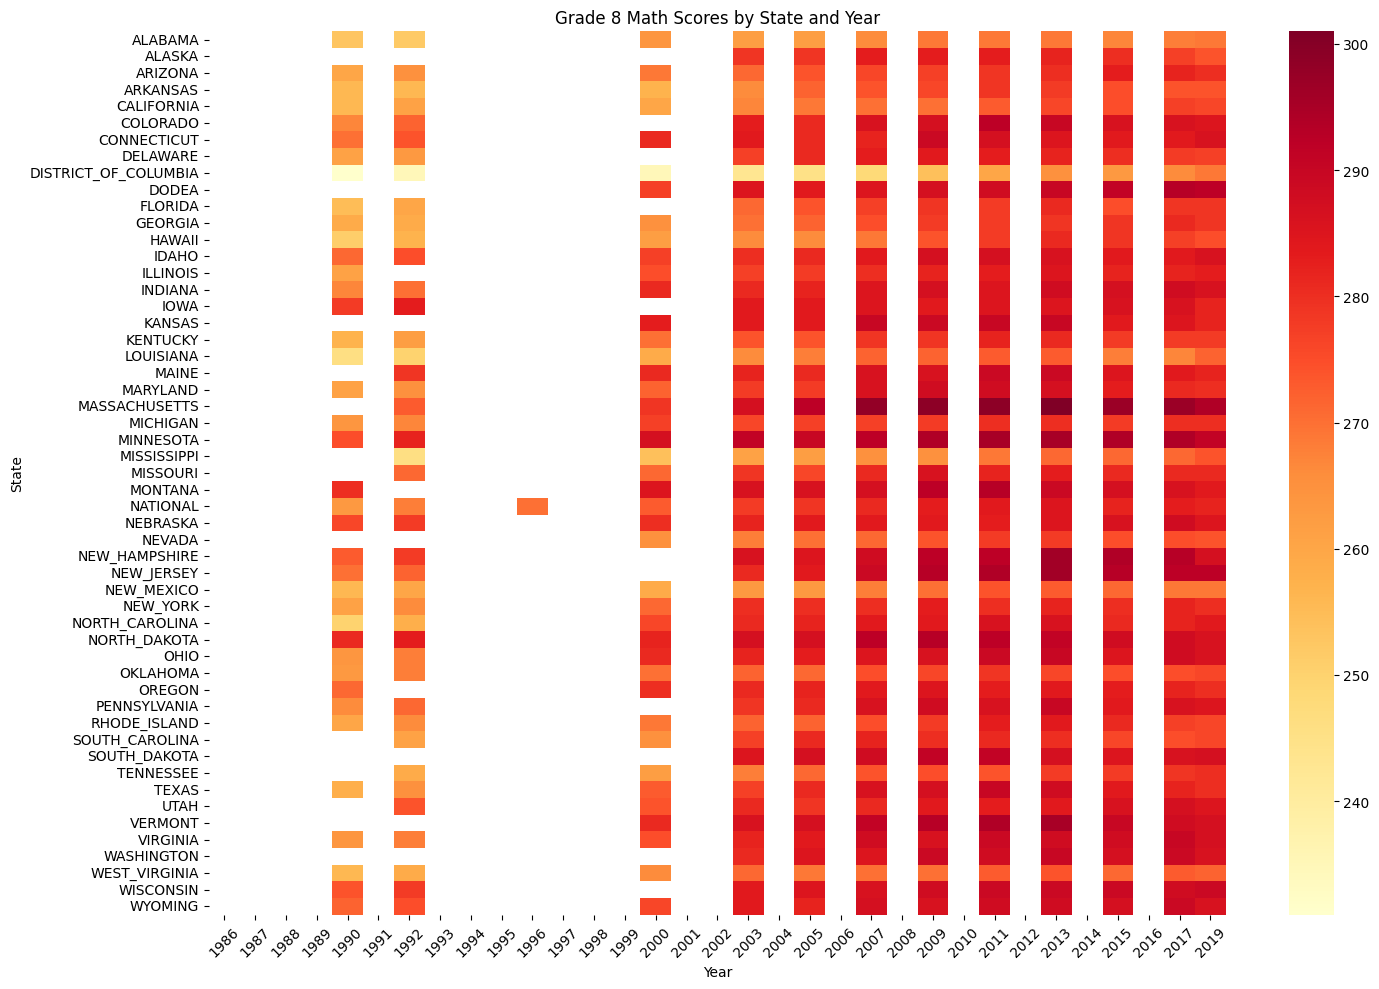

In [12]:
# Pivot the data to create a matrix of states, years, and scores
pivot_df = df.pivot(index='STATE', columns='YEAR', values=RESULT_COLUMN)

# Create a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_df, cmap='YlOrRd', annot=False)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('State')
plt.title('Grade 8 Math Scores by State and Year')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


**Heatmap relating state, year to average 8th grade math score**

<h2> Data Creation </h2>

_Use this space to create train/test data_

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
df: pd.DataFrame = pd.read_csv("../data/states_edu.csv")
df = preprocess(df)
df_features, df_target = generate_features(df)

df_features, df_target = clear_nan(df_features, df_target, current_features) # Optional nan and inf clearing, needed for xgboost and lightgbm

In [15]:
# X_train, X_test, y_train, y_test = train_test_split(
#      X, y, test_size=, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.2, random_state=seed)
X, Y, index = clean_data(X_train, y_train)
XX, YY, _ = clean_data(X_test, y_test)

<h2> Prediction </h2>

ML Models [Resource](https://medium.com/@vijaya.beeravalli/comparison-of-machine-learning-classification-models-for-credit-card-default-data-c3cf805c9a5a)

In [16]:
# import your sklearn class here
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [17]:
# create your model here
# model = 
model_dict = {
    # 'lgb': LGBMRegressor(objective='regression_l1', n_estimators=300, random_state=seed),
    'xgb': XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=100, random_state=seed),
    'cbt': CatBoostRegressor(objective='MAE', iterations=800, random_state=seed),

}

In [18]:
def train(model, X, Y, index, N_fold: int = 5):
    for i in range(N_fold):
        model.fit(X[index%N_fold!=i], Y[index%N_fold!=i], 
                    eval_set=[(X[index%N_fold==i], Y[index%N_fold==i])],
                    )

In [19]:

for model in model_dict.values():
    train(model, X, Y, index)

[0]	validation_0-mae:5.56190
[1]	validation_0-mae:4.96103
[2]	validation_0-mae:4.46118
[3]	validation_0-mae:4.30633
[4]	validation_0-mae:4.23277
[5]	validation_0-mae:4.17754
[6]	validation_0-mae:4.11383
[7]	validation_0-mae:4.01601
[8]	validation_0-mae:3.92022
[9]	validation_0-mae:3.86599
[10]	validation_0-mae:3.74813
[11]	validation_0-mae:3.52752
[12]	validation_0-mae:3.45973
[13]	validation_0-mae:3.46475
[14]	validation_0-mae:3.45950
[15]	validation_0-mae:3.45185
[16]	validation_0-mae:3.44475
[17]	validation_0-mae:3.45918
[18]	validation_0-mae:3.46327
[19]	validation_0-mae:3.42831
[20]	validation_0-mae:3.42689
[21]	validation_0-mae:3.45820
[22]	validation_0-mae:3.41957
[23]	validation_0-mae:3.38226
[24]	validation_0-mae:3.38549
[25]	validation_0-mae:3.38309
[26]	validation_0-mae:3.40263
[27]	validation_0-mae:3.39219
[28]	validation_0-mae:3.39421
[29]	validation_0-mae:3.38913
[30]	validation_0-mae:3.37876
[31]	validation_0-mae:3.37639
[32]	validation_0-mae:3.35260
[33]	validation_0-ma

In [20]:
def predict(model_dict, X_feat):
    return np.mean([model.predict(X_feat) for model in model_dict.values()], 0)

In [21]:
y_pred = predict(model_dict, XX)
y_pred

array([287.36788351, 275.27951817, 279.361826  , 283.22726607,
       285.21997768, 278.04503414, 275.96158934, 285.11711688,
       294.17058288, 273.21110985, 284.91247697, 285.5358175 ,
       275.41842675, 270.81247125, 278.42350833, 284.6952774 ,
       279.55123133, 279.3054883 , 286.7074305 , 286.40158139,
       274.09217104, 278.56510444, 283.32965577, 278.51547592,
       282.53063807, 287.95660646, 275.06007323, 284.01502632,
       280.29011371, 285.42225373, 287.23150024, 277.55799652,
       277.69557462, 275.59753811, 284.51208463, 289.90575242,
       268.87409427, 278.15417527, 285.85020197, 271.97155084,
       288.6766776 , 284.63132768, 278.91756467, 282.01743182,
       280.88285852, 285.42116595, 285.45914441, 287.85536312,
       289.39514333, 274.07199263, 279.80822616, 288.3579649 ,
       279.50143436, 284.3596519 , 284.12469076, 271.52763373,
       278.50461102, 288.11941957, 265.61452947, 283.43732674,
       286.36811933, 279.3899965 , 286.22916873, 276.65

## Evaluation

Choose some metrics to evaluate the performance of your model, some of them are mentioned in the tutorial.

In [22]:
# Calculate baseline predictions (mean of Y)
y_baseline = np.full_like(YY, np.mean(Y))

# Calculate metrics for the model
mse_model = mean_squared_error(YY, y_pred)
mae_model = mean_absolute_error(YY, y_pred)
r2_model = r2_score(YY, y_pred)

# Calculate metrics for the baseline
mse_baseline = mean_squared_error(YY, y_baseline)
mae_baseline = mean_absolute_error(YY, y_baseline)
r2_baseline = r2_score(YY, y_baseline)

print("Model Performance:")
print(f"Mean Squared Error: {mse_model}")
print(f"Mean Absolute Error: {mae_model}")
print(f"R-squared Score: {r2_model}")

print("\nBaseline Performance:")
print(f"Mean Squared Error: {mse_baseline}")
print(f"Mean Absolute Error: {mae_baseline}")
print(f"R-squared Score: {r2_baseline}")


Model Performance:
Mean Squared Error: 16.883307335299463
Mean Absolute Error: 3.2610532708101445
R-squared Score: 0.7083530896423568

Baseline Performance:
Mean Squared Error: 57.89117177904516
Mean Absolute Error: 6.278011377689833
R-squared Score: -2.807809117211235e-05


In [23]:
feature_importance = model.feature_importances_
sorted_features = sorted(zip(current_features, feature_importance), key=lambda x: x[1], reverse=True)
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

GRADE_8_TO_HS_RATIO: 9.625774809886419
TOTAL_EXPENDITURE_PER_STUDENT: 5.27827808933108
OTHER_EXPENDITURE_LOCAL_REVENUE_REL: 4.703766357659609
TOTAL_REVENUE_PER_STUDENT: 3.4894807393721217
CAPITAL_OUTLAY_EXPENDITURE_TOTAL_REVENUE_REL: 3.083882126258424
OTHER_EXPENDITURE: 3.0576205039518642
OTHER_EXPENDITURE_TOTAL_REVENUE_REL: 2.7067195587076784
INSTRUCTION_EXPENDITURE_PER_STUDENT: 2.691308700102689
SUPPORT_SERVICES_EXPENDITURE_TOTAL_EXPENDITURE_REL: 2.6708165761797233
CAPITAL_OUTLAY_EXPENDITURE: 2.5412347009567093
OTHER_EXPENDITURE_STATE_REVENUE_REL: 2.485546218587996
LOCAL_REVENUE_FEDERAL_REVENUE_REL: 2.474672758436262
FEDERAL_REVENUE_TOTAL_EXPENDITURE_REL: 2.3397682861967786
SUPPORT_SERVICES_EXPENDITURE_TOTAL_REVENUE_REL: 2.2111862236458335
GRADE_8_TO_ALL_RATIO: 2.0789730813240124
LOCAL_REVENUE: 2.0766298641998464
TOTAL_EXPENDITURE: 2.0232239985897076
TOTAL_REVENUE: 2.0076213805239616
TOTAL_EXPENDITURE_TOTAL_REVENUE_REL: 1.9743551348616664
SUPPORT_SERVICES_EXPENDITURE_STATE_REVENUE_RE

We have copied over the graphs that visualize the model's performance on the training and testing set. 

Change `col_name` and modify the call to `plt.ylabel()` to isolate how a single predictor affects the model.

In [24]:
from math import ceil, sqrt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def feature_importance_mosaic(model_dict, X, y, feature_importance, feature_names, variation, n_top_features=16):
    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)
    sorted_features = [feature_names[i] for i in sorted_idx[::-1]]
    sorted_importance = feature_importance[sorted_idx[::-1]]

    # Select top N features
    top_features = sorted_features[:n_top_features]
    top_importance = sorted_importance[:n_top_features]

    # Calculate grid dimensions
    n_plots = len(top_features)
    n_cols = ceil(sqrt(n_plots))
    n_rows = ceil(n_plots / n_cols)

    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    fig.suptitle(f"Feature Importance and Model Performance for {variation}", fontsize=16, y=1.05)
    
    # Add subtitle to explain Imp and Improvement
    plt.figtext(0.5, 0.98, 
                "Imp: Feature Importance (0-1)\nImprovement: % improvement over polynomial fit baseline", 
                ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    # Add explanation about the baseline
    plt.figtext(0.5, 0.95,
             "* Baseline: Quadratic polynomial fit for each feature", 
             ha='center', fontsize=8, style='italic')
    
    # Flatten axes array for easier indexing
    axes = axes.flatten()

    # Make predictions for all data
    predictions = predict(model_dict, X)

    # Calculate overall MAE
    overall_mae = mean_absolute_error(y, predictions)

    # Calculate baseline MAE using mean of polynomial fits for all features
    baseline_predictions = np.zeros_like(y)
    valid_feature_count = 0
    for feature in feature_names:
        try:
            valid_mask = ~(np.isnan(X[feature]) | np.isinf(X[feature]) | np.isnan(y) | np.isinf(y) | np.isnan(predictions) | np.isinf(predictions))
            x_valid = X[feature][valid_mask].values
            y_valid = y[valid_mask]
            
            # Skip if not enough valid data points
            if len(x_valid) < 2:
                continue
            
            # Scale extremely large values
            x_max = np.finfo(np.float64).max
            x_valid = np.clip(x_valid, -x_max, x_max)
            
            # Calculate baseline predictions using polynomial regression
            poly = PolynomialFeatures(degree=2)
            X_poly = poly.fit_transform(x_valid.reshape(-1, 1))
            poly_reg = LinearRegression()
            poly_reg.fit(X_poly, y_valid)

            x_full = X[feature].values
            x_full[np.isnan(x_full) | np.isinf(x_full)] = 0
            x_full = np.clip(x_full, -x_max, x_max)
            
            # Predict on full data
            X_poly_full = poly.transform(x_full.reshape(-1, 1))
            feature_prediction = poly_reg.predict(X_poly_full)
        

            baseline_predictions += feature_prediction
            valid_feature_count += 1
            
        except Exception as e:
            print(f"Skipping feature {feature} due to error: {str(e)}")
    
    if valid_feature_count > 0:
        baseline_predictions /= valid_feature_count
        baseline_mae = mean_absolute_error(y, baseline_predictions)
        
        # Calculate overall improvement percentage
        overall_improvement = (baseline_mae - overall_mae) / baseline_mae * 100
    else:
        overall_improvement = 0
        print("Warning: No valid features for baseline calculation")



    # Create scatter plots
    for i, (feature, importance) in enumerate(zip(top_features, top_importance)):
        ax = axes[i]
        
        # Remove NaN, inf values and extremely large values
        valid_mask = ~(np.isnan(X[feature]) | np.isinf(X[feature]) | np.isnan(y) | np.isinf(y) | np.isnan(predictions) | np.isinf(predictions))
        x_valid = X[feature][valid_mask].values
        y_valid = y[valid_mask]
        pred_valid = predictions[valid_mask]
        
        # Skip if not enough valid data points
        if len(x_valid) < 2:
            ax.text(0.5, 0.5, "Insufficient valid data", ha='center', va='center')
            continue
        
        # Scale extremely large values
        x_max = np.finfo(np.float64).max
        x_valid = np.clip(x_valid, -x_max, x_max)
        
        # Calculate baseline predictions using polynomial regression
        poly = PolynomialFeatures(degree=2)
        X_poly = poly.fit_transform(x_valid.reshape(-1, 1))
        poly_reg = LinearRegression()
        poly_reg.fit(X_poly, y_valid)
        y_baseline = poly_reg.predict(X_poly)
        
        # Calculate MAE for model and baseline
        mae_model = mean_absolute_error(y_valid, pred_valid)
        mae_baseline = mean_absolute_error(y_valid, y_baseline)
        
        # Calculate Relative Improvement Score
        rel_improvement = (mae_baseline - mae_model) / mae_baseline * 100

        sns.scatterplot(x=x_valid, y=y_valid, ax=ax, alpha=0.5, color="red", label="True")
        sns.scatterplot(x=x_valid, y=pred_valid, ax=ax, alpha=0.5, color="green", label="Predicted")
        
        # Plot the polynomial baseline
        x_range = np.linspace(x_valid.min(), x_valid.max(), 100).reshape(-1, 1)
        y_poly = poly_reg.predict(poly.transform(x_range))
        ax.plot(x_range, y_poly, color='blue', label='Baseline')
        
        ax.set_title(f"{feature}\nImp: {importance:.4f}, Improvement: {rel_improvement:.1f}%")
        ax.set_xlabel(feature)
        ax.set_ylabel("Grade 8 Math Score")
        ax.legend(["True", "Predicted", "Baseline"])

        # Adjust plot size based on importance
        box = ax.get_position()
        size_factor = 0.5 + (importance / max(top_importance)) * 0.5
        ax.set_position([box.x0, box.y0 + 0.05, box.width * size_factor, box.height * size_factor])

    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.4)  # Increase vertical gap
    
    # Add overall MAE to the figure
    fig.text(0.5, 0.02, f'Overall Mean Absolute Error: {overall_mae:.2f}', 
             ha='center', va='center', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    improvement_text = f'Overall Improvement: {overall_improvement:.1f}%\nover mean of all feature fits'
    fig.text(0.02, 0.98, improvement_text, 
             ha='left', va='top', 
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8),
             fontsize=10, fontweight='bold')
    
    
    plt.show()

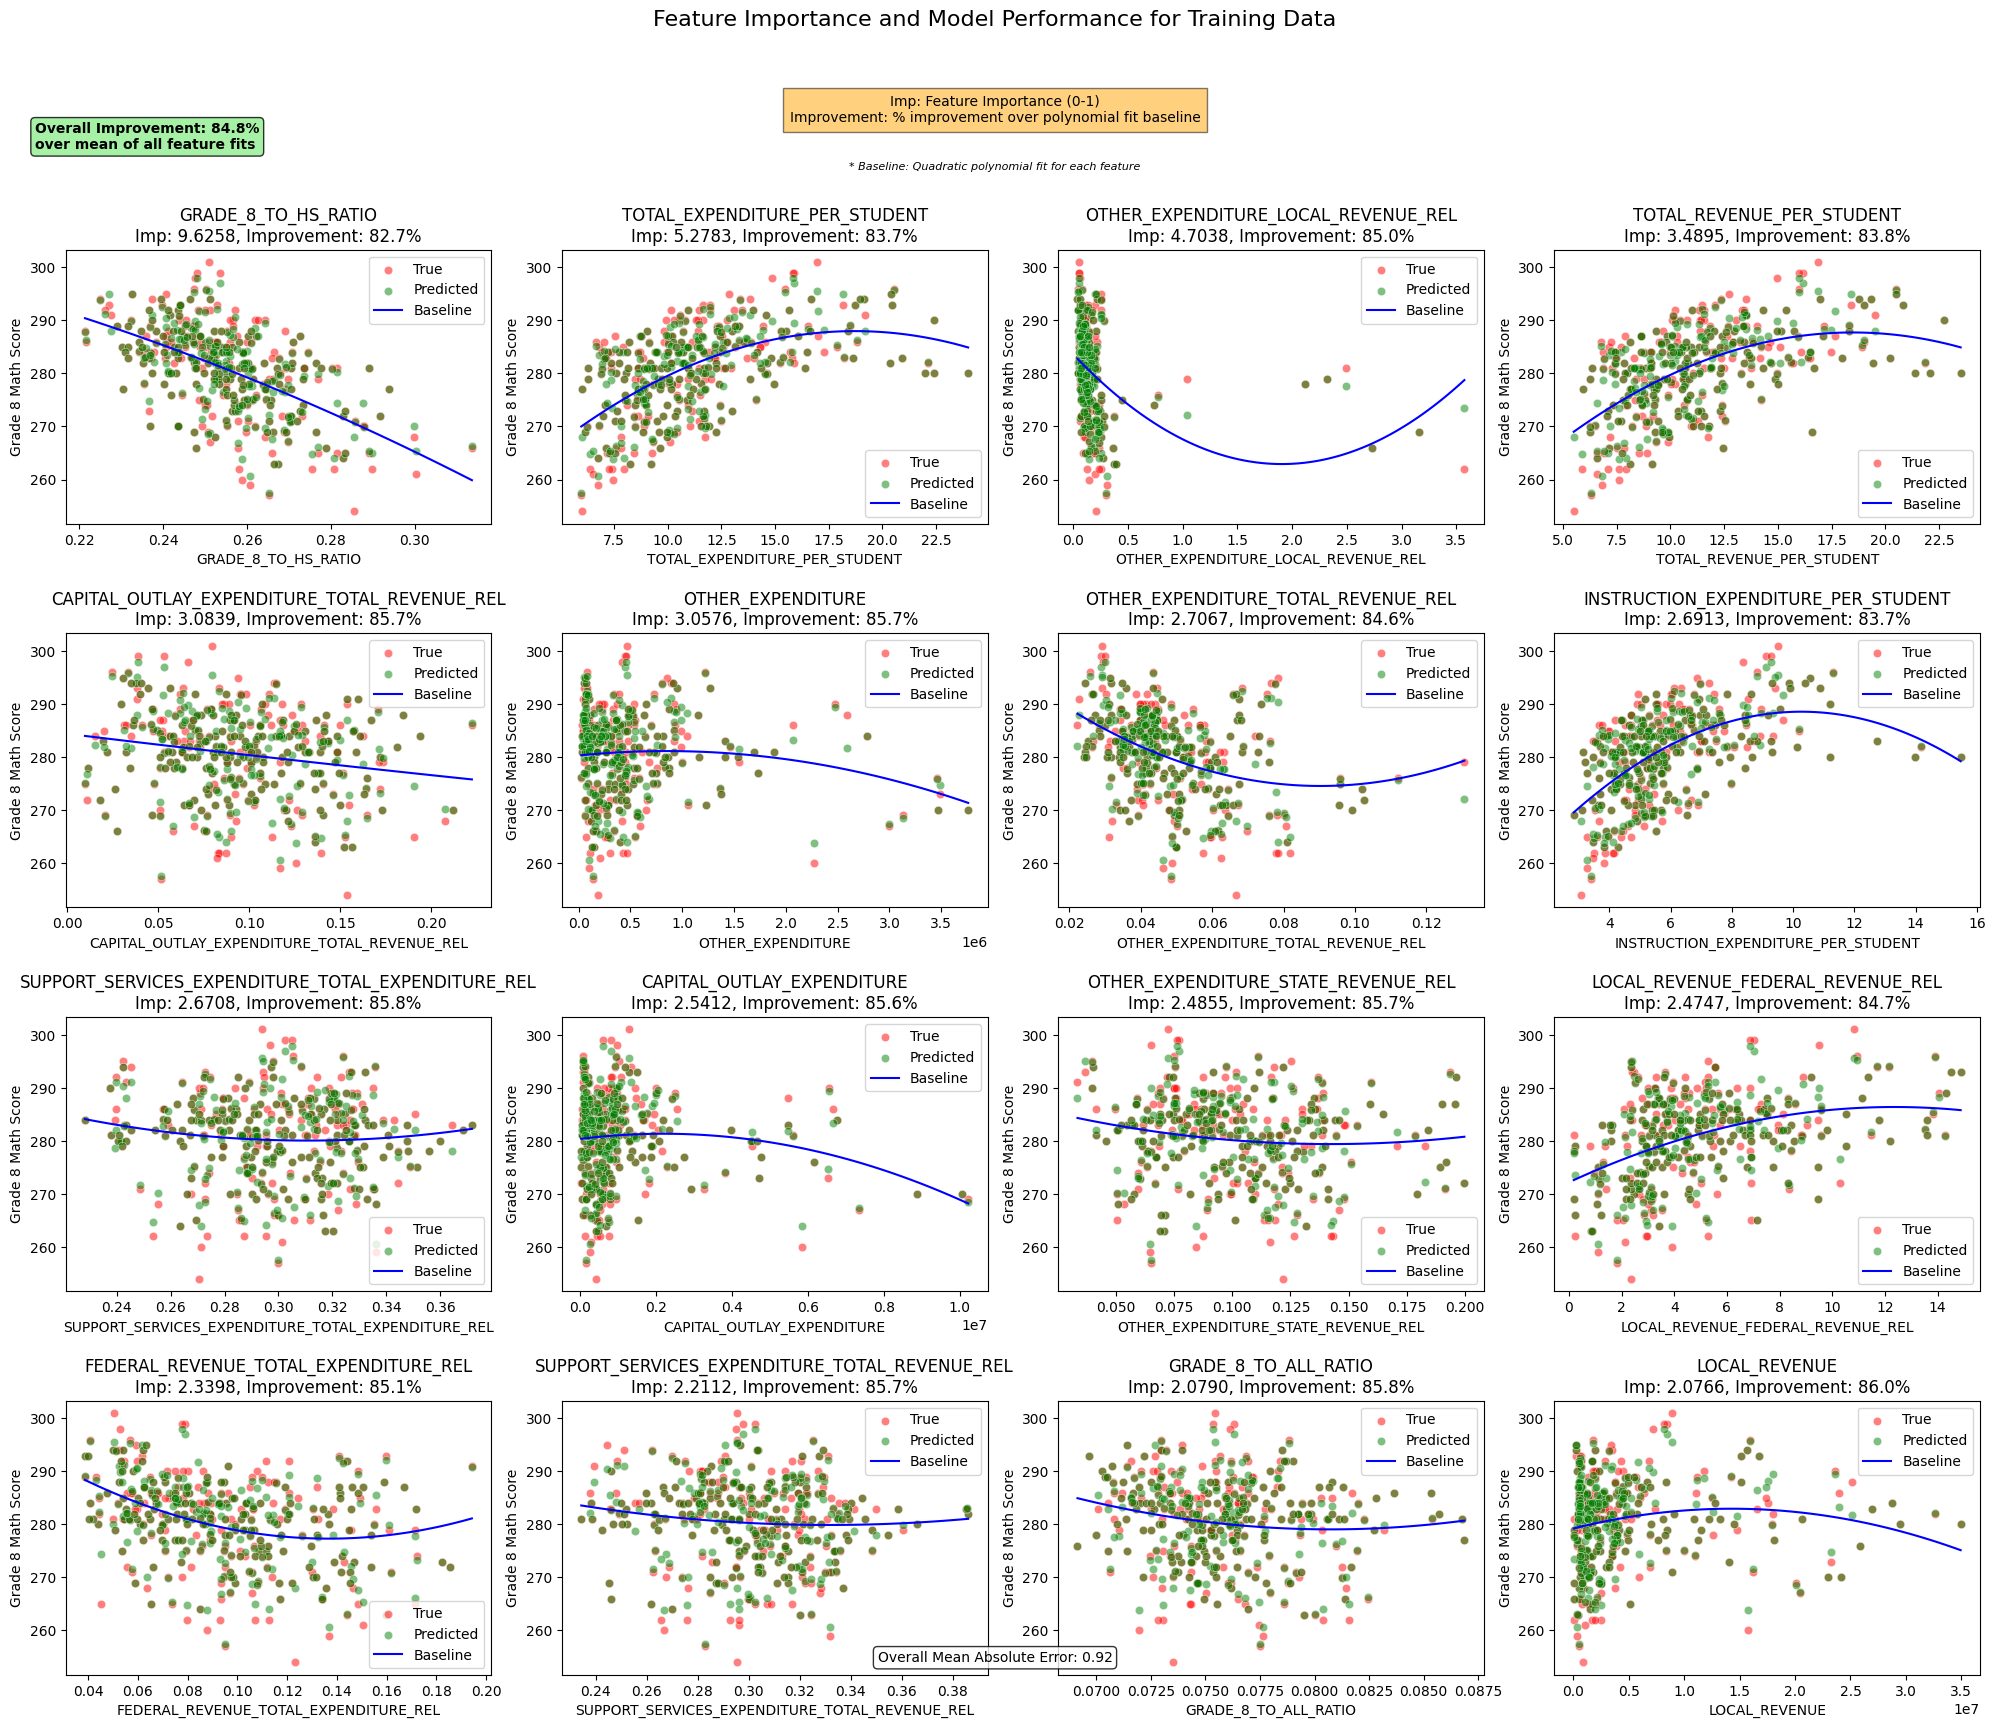

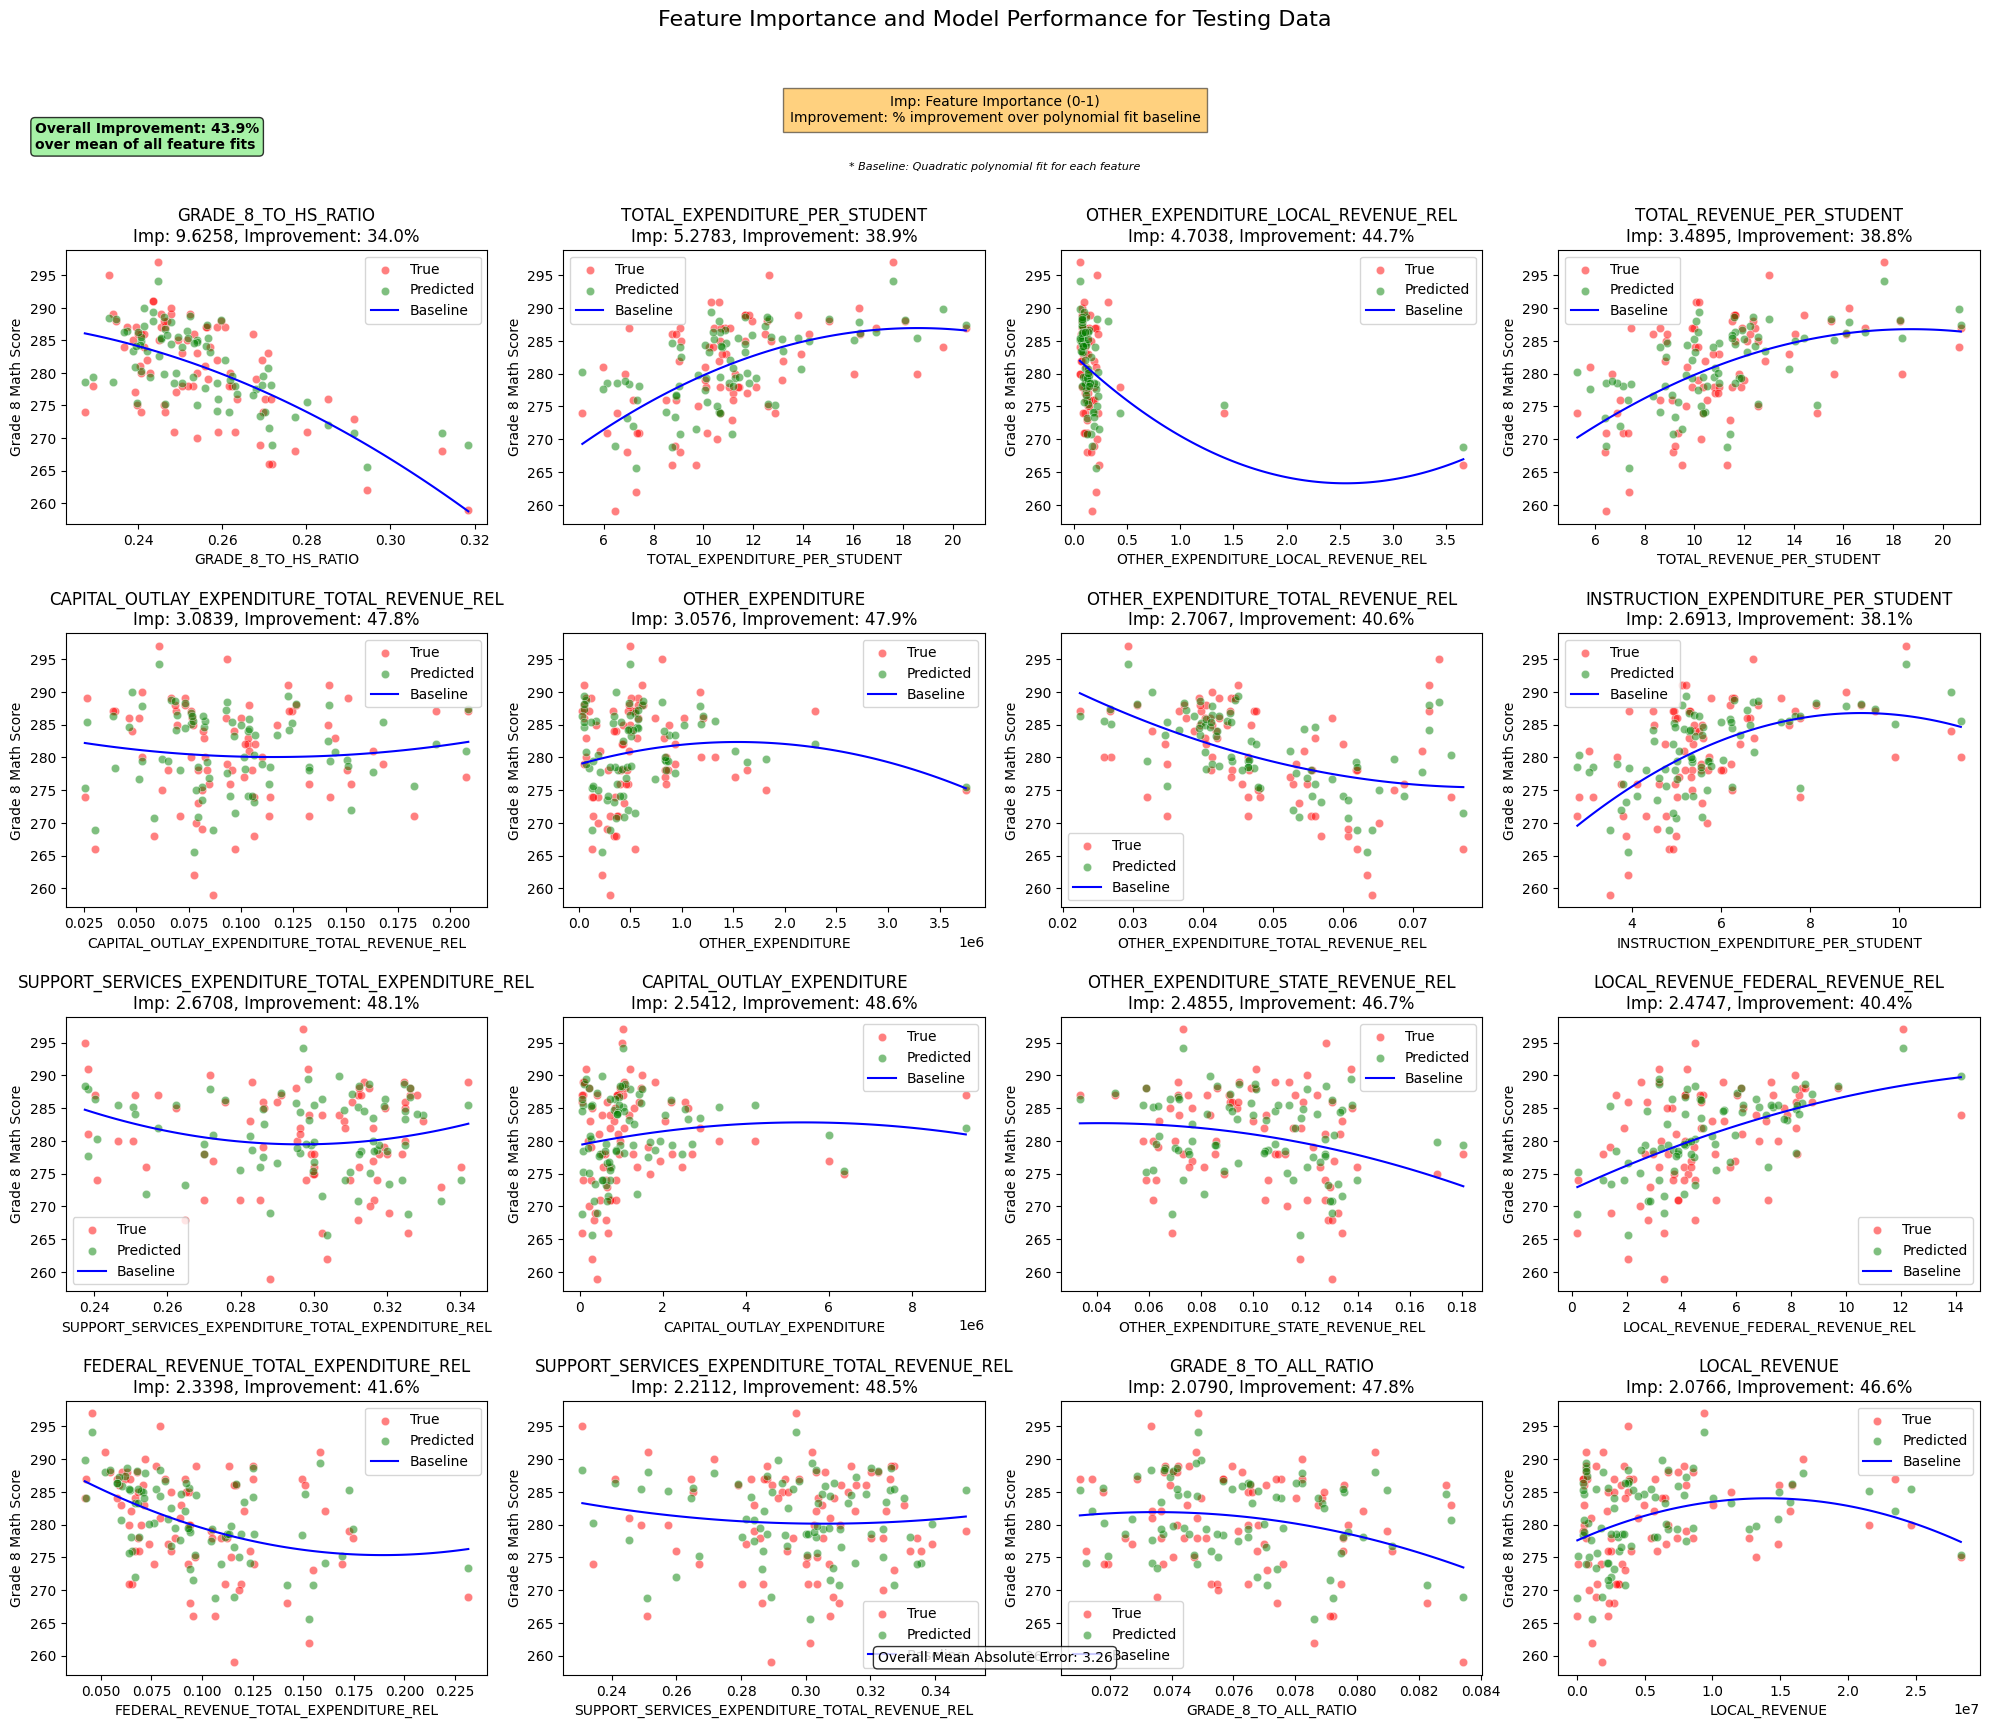

In [25]:

X_, Y_ = _clean_data(X_train, y_train)
XX_, YY_ = _clean_data(X_test, y_test)

feature_importance_mosaic(model_dict, X_, Y_, feature_importance, current_features, 'Training Data')
feature_importance_mosaic(model_dict, XX_, YY_, feature_importance, current_features, "Testing Data")

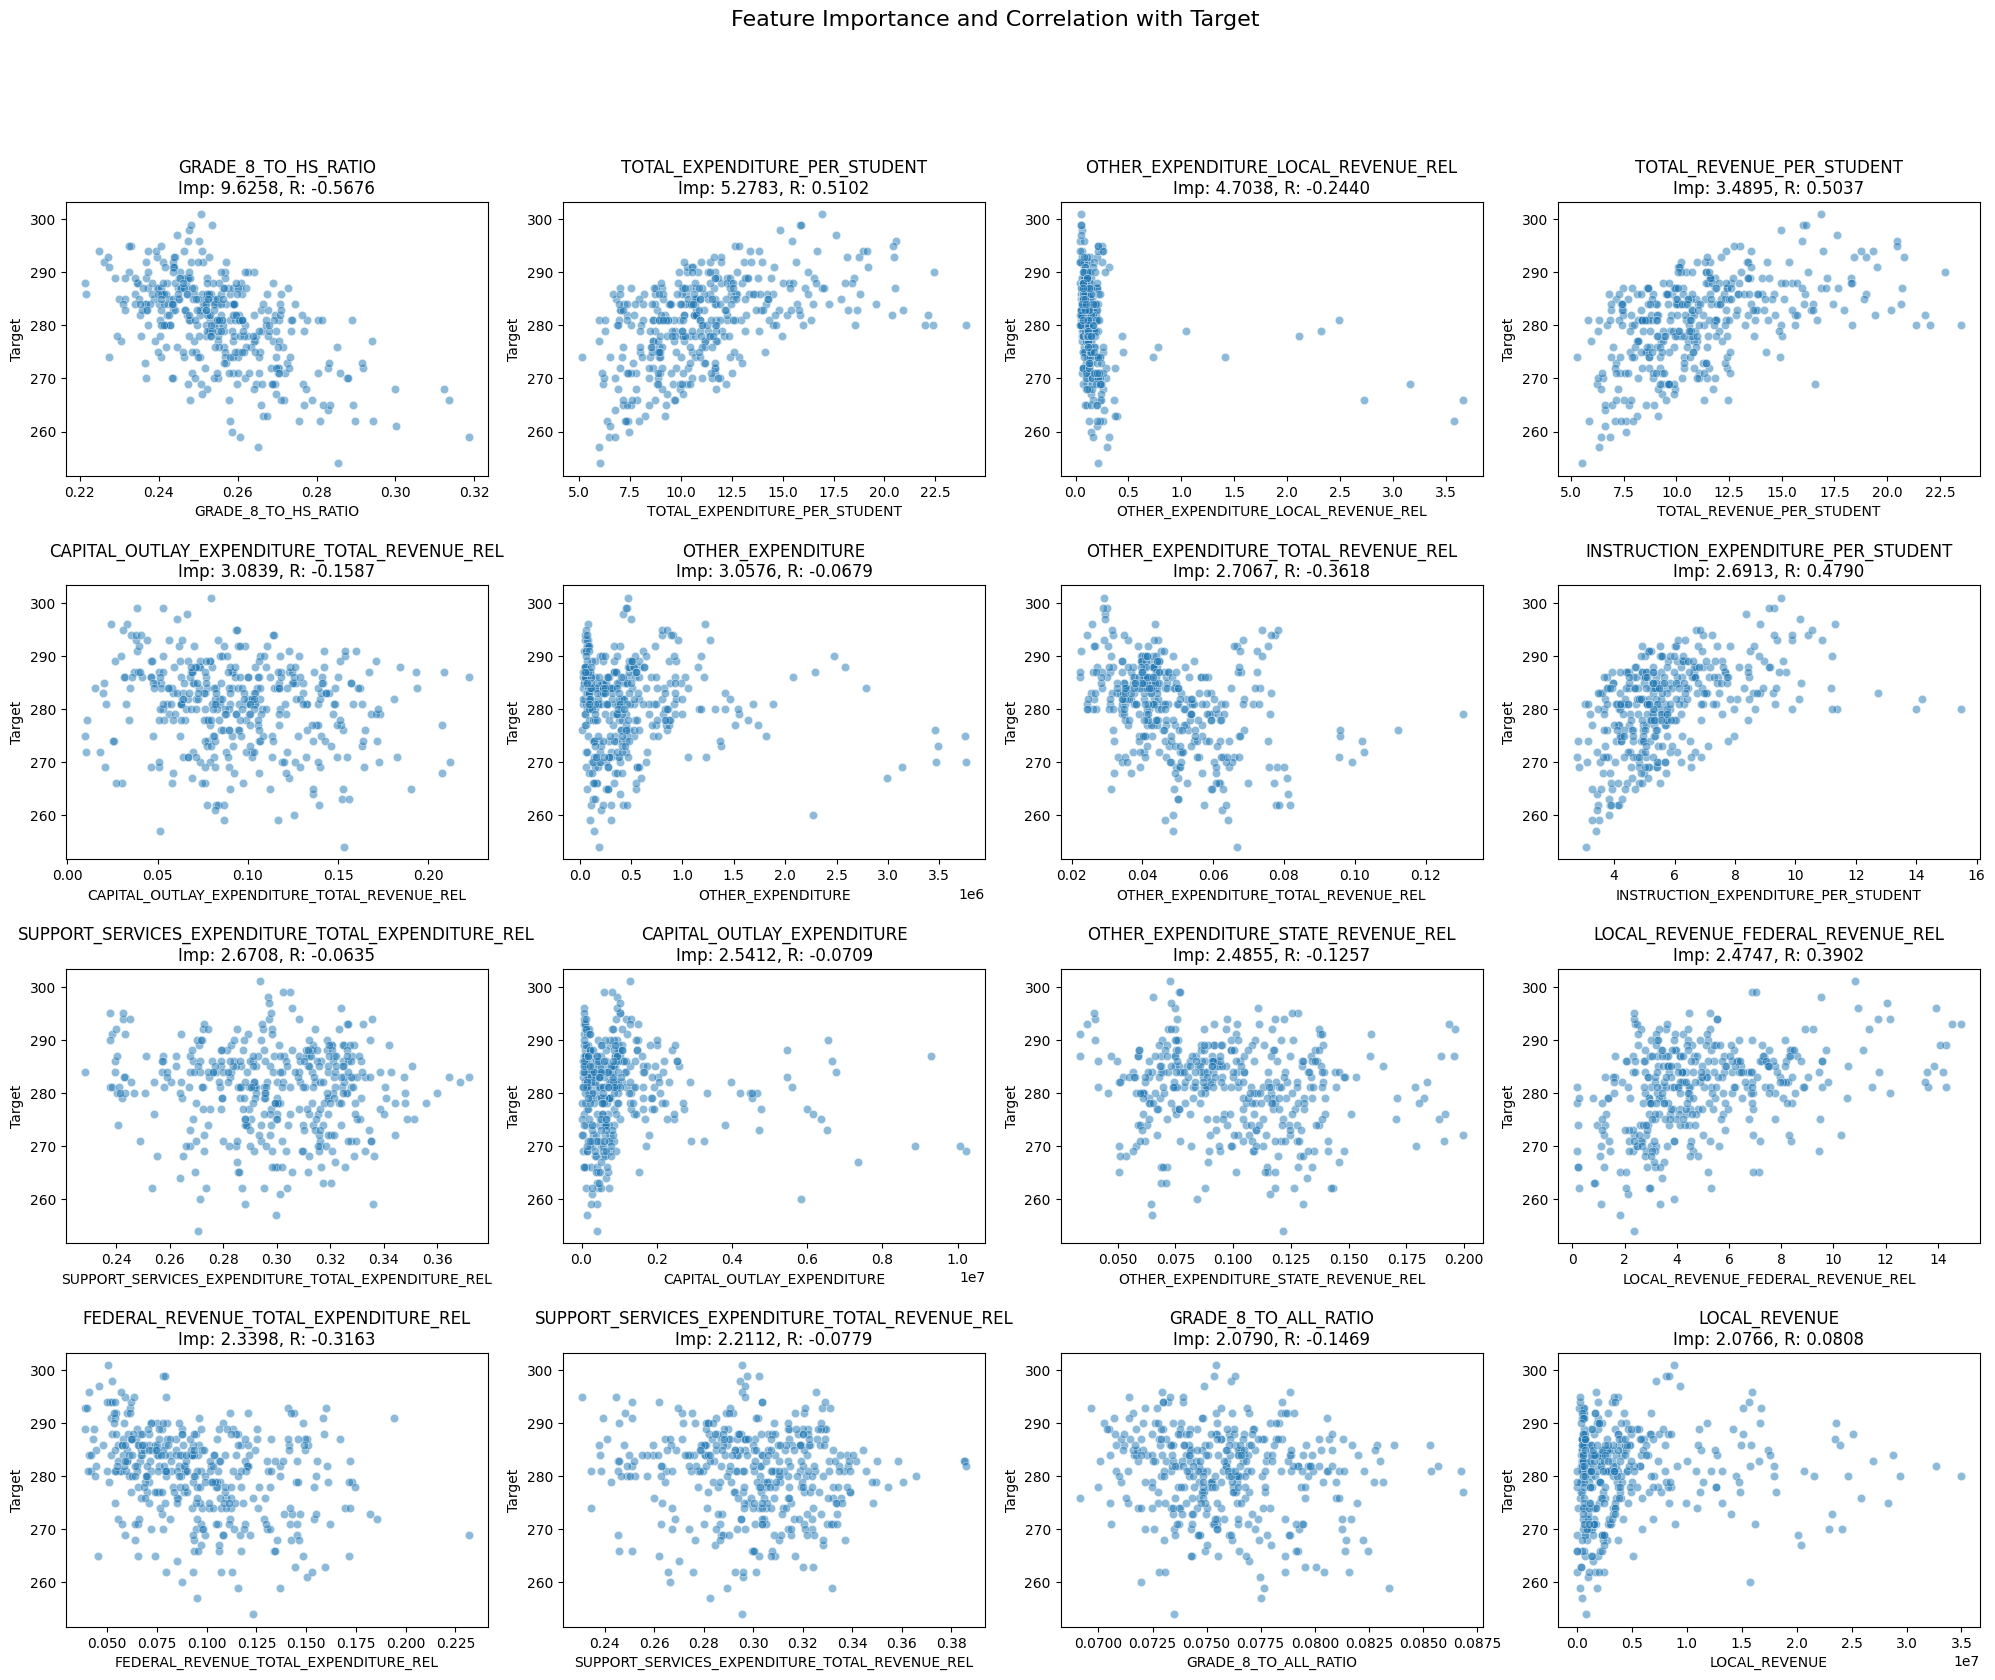

In [26]:
def feature_importance_mosaic(X, y, feature_importance, feature_names, n_top_features=16):
    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)
    sorted_features = [feature_names[i] for i in sorted_idx[::-1]]
    sorted_importance = feature_importance[sorted_idx[::-1]]

    # Select top N features
    top_features = sorted_features[:n_top_features]
    top_importance = sorted_importance[:n_top_features]

    # Calculate grid dimensions
    n_plots = len(top_features)
    n_cols = ceil(sqrt(n_plots))
    n_rows = ceil(n_plots / n_cols)

    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    fig.suptitle("Feature Importance and Correlation with Target", fontsize=16, y=1.02)

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    # Create scatter plots
    for i, (feature, importance) in enumerate(zip(top_features, top_importance)):
        ax = axes[i]
        
        # Remove NaN values for correlation calculation
        valid_mask = ~(np.isnan(X[feature]) | np.isnan(y))
        x_valid = X[feature][valid_mask]
        y_valid = y[valid_mask]
        
        # Calculate correlation
        if len(x_valid) > 1:
            r = np.corrcoef(x_valid, y_valid)[0, 1]
        else:
            r = np.nan

        sns.scatterplot(x=X[feature], y=y, ax=ax, alpha=0.5)
        ax.set_title(f"{feature}\nImp: {importance:.4f}, R: {r:.4f}")
        ax.set_xlabel(feature)
        ax.set_ylabel("Target")

        # Adjust plot size based on importance
        box = ax.get_position()
        size_factor = 0.5 + (importance / max(top_importance)) * 0.5
        ax.set_position([box.x0, box.y0 + 0.05, box.width * size_factor, box.height * size_factor])

    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.subplots_adjust(top=0.9, hspace=0.4)  # Increase vertical gap
    plt.show()

feature_importance_mosaic(df_features, df_target, feature_importance, current_features)